<a href="https://www.kaggle.com/code/wattuginu/ica-exploration?scriptVersionId=193767170" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ICA Exploration Trial

## import library

In [1]:
!pip install scikit-bio

import branca.colormap as cm
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from IPython.display import display
from shapely.geometry import Point
from skbio.stats.composition import clr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - \ | / - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ | / - \ | / done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 73.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.2-cp310-cp310-linux_x86_64.whl size=2504430 sha256=a6096e44e79ce087527ec1aaef295a91f84f59fc9e5debcc0fd9669995f6570f
  Stored in directory: /root/.cache/pip/wheels/f3/9c/ed/c2b94011fd3765a19330df93f81265e178098dd86c047c1566
  Created wheel for biom-format: filename=biom_format-2.1.16-cp310-cp310-linux_x86_64.whl size=11812703 sha256=79466c7b394740fc603e

## Preprocessing

In [2]:
def preprocessing(df):
    # define list
    elements = [
        "Sr", "Rb", "Ba", "La", 
        "Ce", "Eu", "Er", "Yb", 
        "Th", "Nb", "Zr", "Y"
    ]
    
    frame = [
        "Location", "Longitude", "Latitude", "AGE", "Sample Name", "Island Arc"
    ]
    
    # Separate the data based on the variable
    elementsData = df[elements]
    frameData = df[frame]
    
    # change inf value to nan and 0 to 1e-6
    elementData = elementsData.copy()
    elementData.loc[:, :] = elementData.loc[:, :].replace([np.inf, -np.inf], np.nan).replace([0], np.nan)
    
    # Drop Na value
    cleanData = elementData.dropna(axis=0)
    
    # Normalize to 1
    df_normalized = cleanData.div(cleanData.sum(axis=0), axis=1)
    
    # logratio transformation
    logRatioData = clr(df_normalized)
    logRatioDataframe = pd.DataFrame(data=logRatioData, columns=elements, index=df_normalized.index)

    # HFSE
    # La, Ce, Nd, Eu, Gd, Dy, Er, Yb, Th, Nb, Zr, Y
    
    # LILE
    # Sr, Rb, Ba
    
    # Create new ratio
    # Log LILE/LILE
    logRatioDataframe["Log(Rb/Sr)"] = logRatioDataframe["Rb"] - logRatioDataframe["Sr"]
    # Log LILE/HFSE
    logRatioDataframe["Log(Ba/Nb)"] = logRatioDataframe["Ba"] - logRatioDataframe["Nb"]
    logRatioDataframe["Log(Sr/Y)"] = logRatioDataframe["Sr"] - logRatioDataframe["Y"]
    logRatioDataframe["Log(Rb/Yb)"] = logRatioDataframe["Rb"] - logRatioDataframe["Yb"]
    # Log HFSE/HFSE
    logRatioDataframe["Log(Nb/Er)"] = logRatioDataframe["Nb"] - logRatioDataframe["Er"]
    logRatioDataframe["Log(Nb/Zr)"] = logRatioDataframe["Nb"] - logRatioDataframe["Zr"]
    logRatioDataframe["Log(La/Yb)"] = logRatioDataframe["La"] - logRatioDataframe["Yb"]
    logRatioDataframe["Log(Nb/Y)"] = logRatioDataframe["Nb"] - logRatioDataframe["Y"]
    logRatioDataframe["Log(Th/Ce)"] = logRatioDataframe["Th"] - logRatioDataframe["Ce"]
    logRatioDataframe["Log(Eu/La)"] = logRatioDataframe["Eu"] - logRatioDataframe["La"]
    
    ratio = [
        "Log(Ba/Nb)", "Log(Nb/Zr)", "Log(La/Yb)", "Log(Sr/Y)", "Log(Rb/Sr)", 
        "Log(Th/Ce)", "Log(Eu/La)", "Log(Rb/Yb)", "Log(Nb/Y)", "Log(Nb/Er)"
    ]
    
    # choose only the value
    ratioData = logRatioDataframe[ratio]
    
    # elimination with z-score
    zScore = np.abs(st.zscore(ratioData))
    cleanDataZScore1 = ratioData[(zScore < 3).all(axis=1)]
    cleanDataZScore = cleanDataZScore1
    
    # concat Z-score and frame dataframe
    concatData = pd.concat([cleanDataZScore, frameData], axis=1, join='inner')
    concatData.reset_index(drop=True, inplace=True)
    concatData.to_csv('10_rasio_trace_element.csv')
    preprocessingData = concatData[ratio]
    
    return preprocessingData , concatData, frame, ratio

df = pd.read_csv("/kaggle/input/geochemistry/Dataset.csv")

preprocessingData, concatData, frame, ratio = preprocessing(df)
    


In [3]:
concatData

,Log(Ba/Nb),Log(Nb/Zr),Log(La/Yb),Log(Sr/Y),Log(Rb/Sr),Log(Th/Ce),Log(Eu/La),Log(Rb/Yb),Log(Nb/Y),Log(Nb/Er),Location,Longitude,Latitude,AGE,Sample Name,Island Arc
0,0.787905,-0.759791,-0.402330,0.194879,-0.234209,-0.386319,0.535025,-0.112980,-1.051424,-1.178891,North Sangihe,125.800,4.500,PLIOCENE [16735],s_PJ-40-78 [16735],Sangihe
1,0.650488,-0.726189,-0.332799,0.068543,-0.312594,-0.321744,0.368156,-0.325580,-0.903239,-1.026008,North Sangihe,125.700,4.233,PLIOCENE [16735],s_PJ-43-78 [16735],Sangihe
2,-0.144927,-0.540558,-0.895870,-1.137030,0.641808,-0.039603,0.590064,-0.751012,-0.217539,-0.416705,North Sangihe,125.716,3.866,PLIOCENE [16735],s_PJ-45-78 [16735],Sangihe
3,0.251929,-0.581265,-0.530006,-0.470269,-0.194750,-0.304354,0.301907,-0.713532,-0.928129,-0.981689,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PBUANG [16735],Sangihe
4,0.481463,-0.425260,-0.412459,0.080823,0.000549,-0.264925,0.464705,-0.021091,-0.803915,-0.952589,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PJ-5-78 [16735],Sangihe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.158629,-0.399259,0.127430,-0.726472,0.853083,0.623088,-0.193864,0.100775,-0.352225,-0.246034,Halmahera,127.330,0.800,NaN,s_GL [25001],Halmahera
139,0.094300,-0.298463,0.072426,-0.364939,0.030278,0.353217,0.062495,-0.140755,-0.517232,-0.303940,Halmahera,127.350,0.300,NaN,s_MK1 [25001],Halmahera
140,-0.128843,-0.383676,-0.098159,-0.682774,0.483914,0.372440,-0.037989,-0.063268,-0.340608,-0.227400,Halmahera,127.350,0.300,NaN,s_MK2 [25001],Halmahera
141,-0.023014,-0.402164,-0.103736,-0.619194,0.589125,0.355978,-0.008430,0.149956,-0.321838,-0.041575,Halmahera,127.350,0.300,NaN,s_MK3 [25001],Halmahera


## PCA

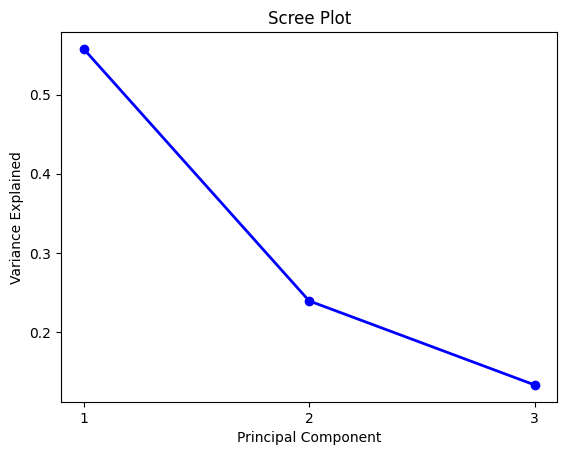

Principal Components: 
 [[0.03163605 0.13547891 0.39403026 0.23012805 0.21021779 0.16185128
  0.31447808 0.4739613  0.4087658  0.45979697]
 [0.04263531 0.17671435 0.16844378 0.47095847 0.75893272 0.22231644
  0.01057525 0.23792155 0.11397733 0.14719466]
 [0.61407116 0.35327977 0.1569575  0.41989681 0.01368946 0.0481113
  0.0184771  0.30965922 0.25255285 0.36694106]]
Explained Variance Ratio: 
 [0.55790492 0.23926204 0.13298256]
Loading Vectors: 
 [[ 0.04535195  0.0400258   0.42978342]
 [ 0.19421618 -0.16589845 -0.24725764]
 [ 0.56486318 -0.15813408  0.10985328]
 [ 0.32990072 -0.44213318  0.29388237]
 [ 0.3013583   0.7124818  -0.00958114]
 [ 0.23202235  0.20870944 -0.03367271]
 [-0.45082093 -0.00992798 -0.01293197]
 [ 0.67944856  0.22335942  0.21672797]
 [ 0.58598736 -0.10700128 -0.17675969]
 [ 0.65914323 -0.13818552 -0.25681907]]


In [4]:
def pc(preprocessingData, numberOfComponent, concatData, frame, ratio):
    # fitting
    pca = PCA(n_components=numberOfComponent, whiten=True)
    principalComponent = pca.fit_transform(preprocessingData)
    
    # Explained variance
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values,
             pca.explained_variance_ratio_,
             'o-',
             linewidth=2,
             color='blue')
    plt.title('Scree Plot')
    plt.xticks([x for x in range(1, numberOfComponent+1)])
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()
    
    # Components
    principalComponents = abs(pca.components_)
    print("Principal Components: \n", principalComponents)
    
    explainedVarianceRatio = pca.explained_variance_ratio_
    print("Explained Variance Ratio: \n", explainedVarianceRatio)
    
    loadingVectors = pca.components_.T * np.sqrt(pca.explained_variance_)
    print("Loading Vectors: \n", loadingVectors)
    
    principalComponentsData = pd.DataFrame(data=principalComponent, columns=['PC1', 'PC2', 'PC3'])
    principalComponentsDataframe = pd.concat([principalComponentsData, concatData[frame]], axis=1)
    principalComponentsDataframe.to_csv(f"TraceElement_PCA_{numberOfComponent}.csv")
    
    return principalComponentsDataframe, principalComponent, loadingVectors, explainedVarianceRatio
    
numberOfComponent = 3
principalComponentsDataframe, principalComponent, loadingVectors, explainedVarianceRatio = pc(preprocessingData, numberOfComponent, concatData, frame, ratio)

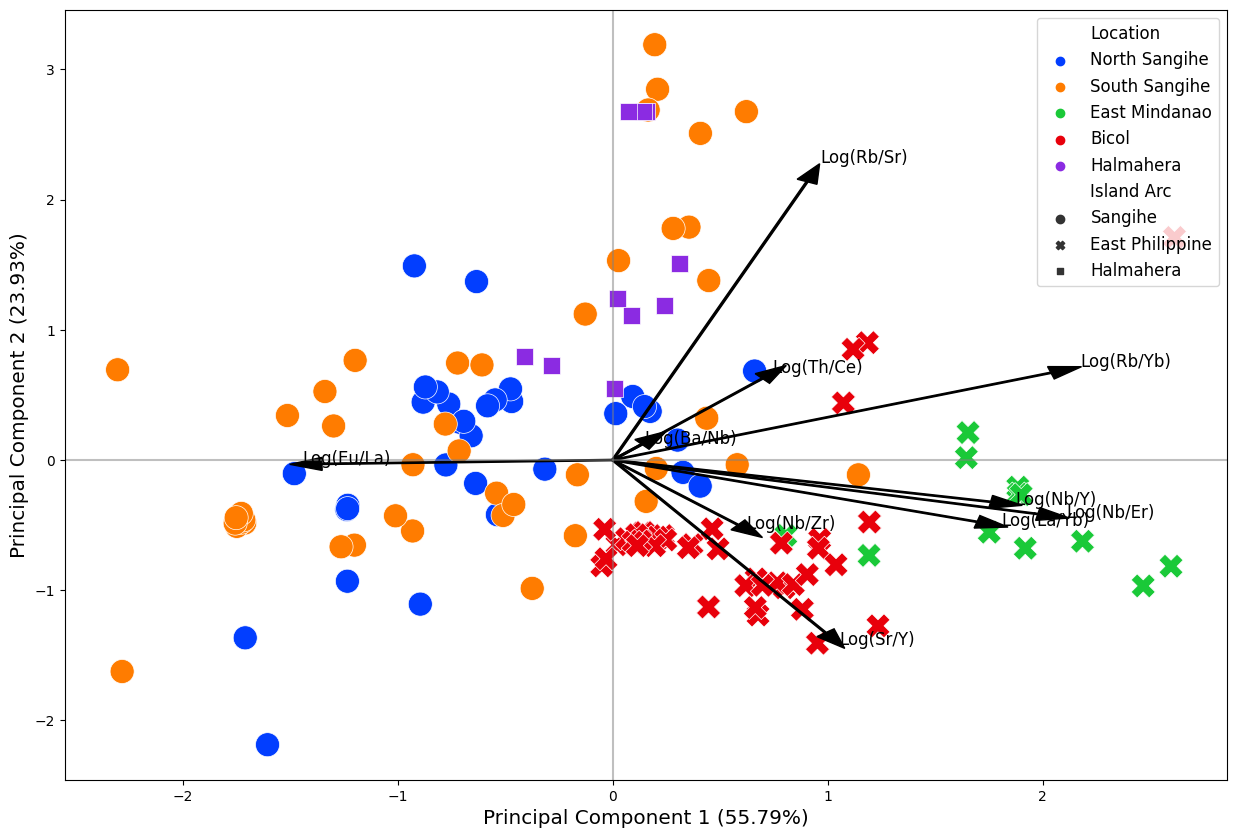

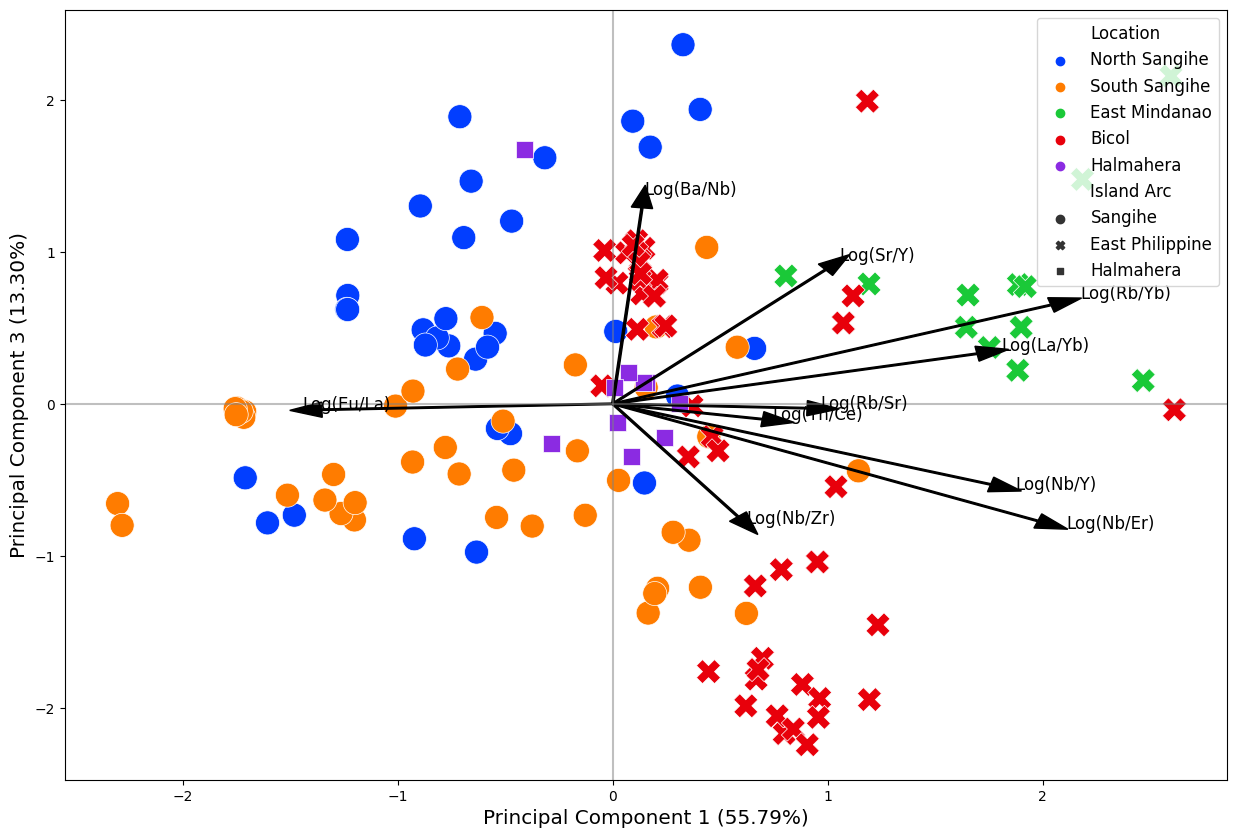

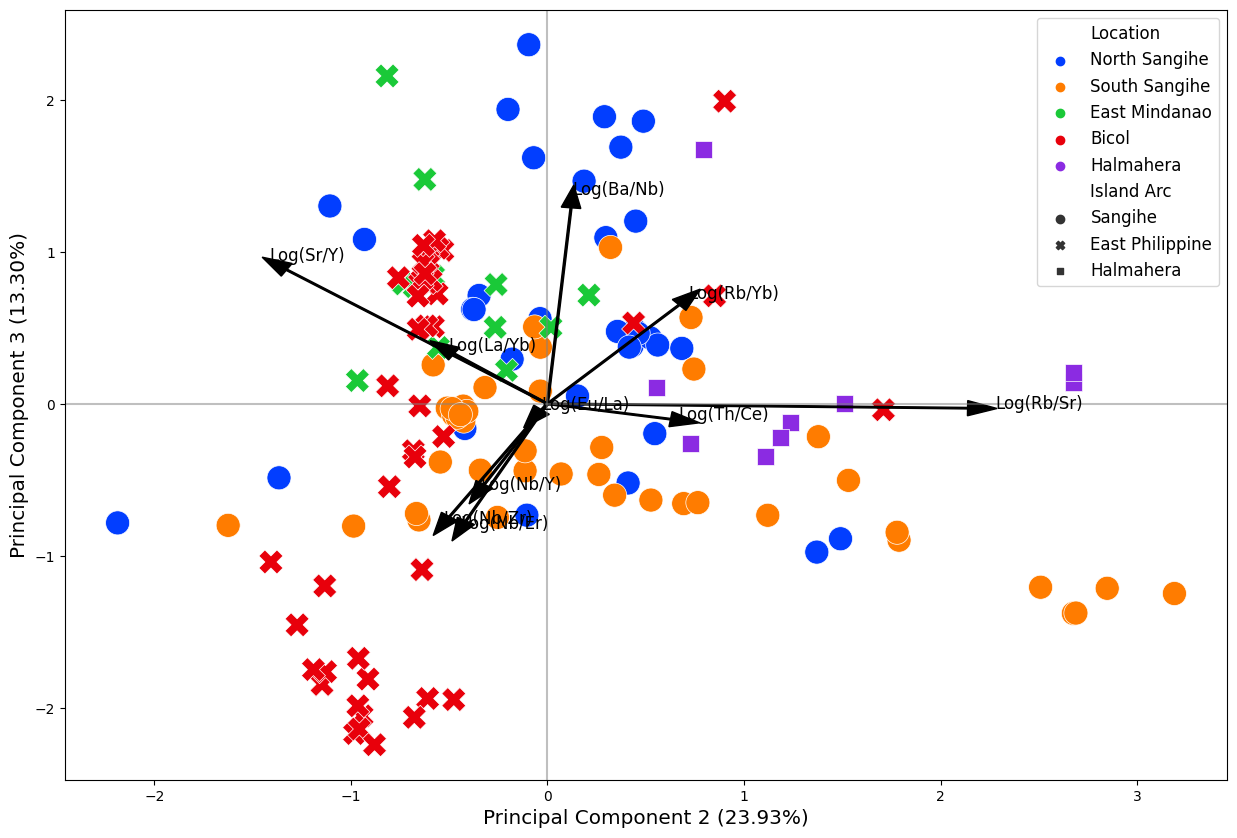

In [5]:
arrow_multiplier = 3
text_multiplier = 3.2

# arrow_multiplier = 1
# text_multiplier = 1

# PC1vsPC2
fig1, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC1",
                y="PC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(ratio):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 0],
              arrow_multiplier * loadingVectors[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 0],
             text_multiplier * loadingVectors[i, 1],
             feature,
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_1vs2.svg')

# PC1vsPC3
fig2, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC1",
                y="PC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(ratio):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 0],
              arrow_multiplier * loadingVectors[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 0],
             text_multiplier * loadingVectors[i, 2],
             feature,
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_1vs3.svg')

# PC2vsPC3
fig3, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC2",
                y="PC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(ratio):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 1],
              arrow_multiplier * loadingVectors[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 1],
             text_multiplier * loadingVectors[i, 2],
             feature,
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_2vs3.svg')

## ICA

In [6]:
def ic(whitenedData, concatData, frame):
    ica = FastICA(whiten= False, max_iter=100000, random_state=12)
    icaData = ica.fit_transform(whitenedData)
    icVectors = icaData.T
    icaIndependentComponent = pd.DataFrame(data=icaData, columns=['IC1', 'IC2', 'IC3'])
    icaDataframe = pd.concat([icaIndependentComponent, concatData[frame]], axis=1)
    
    return icaIndependentComponent, icaDataframe, icVectors

icaIndependentComponent, pcIcAndOrginal, icVectors = ic(principalComponent, concatData, frame)

In [7]:
icaIndependentComponent

,IC1,IC2,IC3
0,-0.001233,0.486504,1.979785
1,0.099684,0.426444,1.556215
2,0.925068,-1.536134,-0.124242
3,0.650532,-0.130419,0.878447
4,0.013631,0.066311,1.364737
...,...,...,...
138,-0.302651,-1.438029,0.465533
139,-0.050538,-0.474395,0.300125
140,0.031192,-1.160639,0.083529
141,-0.156397,-1.209512,0.174404


In [8]:
pcIcAndOrginal

,IC1,IC2,IC3,Location,Longitude,Latitude,AGE,Sample Name,Island Arc
0,-0.001233,0.486504,1.979785,North Sangihe,125.800,4.500,PLIOCENE [16735],s_PJ-40-78 [16735],Sangihe
1,0.099684,0.426444,1.556215,North Sangihe,125.700,4.233,PLIOCENE [16735],s_PJ-43-78 [16735],Sangihe
2,0.925068,-1.536134,-0.124242,North Sangihe,125.716,3.866,PLIOCENE [16735],s_PJ-45-78 [16735],Sangihe
3,0.650532,-0.130419,0.878447,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PBUANG [16735],Sangihe
4,0.013631,0.066311,1.364737,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PJ-5-78 [16735],Sangihe
...,...,...,...,...,...,...,...,...,...
138,-0.302651,-1.438029,0.465533,Halmahera,127.330,0.800,NaN,s_GL [25001],Halmahera
139,-0.050538,-0.474395,0.300125,Halmahera,127.350,0.300,NaN,s_MK1 [25001],Halmahera
140,0.031192,-1.160639,0.083529,Halmahera,127.350,0.300,NaN,s_MK2 [25001],Halmahera
141,-0.156397,-1.209512,0.174404,Halmahera,127.350,0.300,NaN,s_MK3 [25001],Halmahera


In [9]:
icVectors

array([[-1.23273693e-03,  9.96842049e-02,  9.25068460e-01,
         6.50531627e-01,  1.36308259e-02,  5.76302426e-01,
         6.07122387e-01, -2.73252261e-01,  3.88759613e-01,
        -7.45256880e-01, -7.60155703e-01, -3.01531446e-01,
        -1.13634943e+00, -1.06065351e+00, -1.83653149e-01,
         1.78213925e+00,  7.82219633e-01,  1.79596272e+00,
         6.75176321e-01,  4.94909539e-01,  4.15583943e-02,
         5.09594915e-01,  2.61600902e-01, -7.51560261e-01,
         3.44999973e-01,  4.10408273e-01,  5.29582444e-01,
         1.64484986e+00,  1.16390242e+00,  9.05564580e-01,
         9.41931330e-01,  9.38933628e-01,  5.62359091e-01,
         5.89022390e-01,  3.63656042e-01,  1.39241746e-01,
         2.38103691e+00,  1.01032180e+00,  7.70381996e-01,
        -1.18575818e-01, -9.13966574e-01, -6.72869634e-01,
         5.20712116e-01,  1.37661309e+00,  1.39853873e+00,
         1.44193587e+00,  2.43020187e+00,  8.27677953e-01,
         2.63471938e-01,  6.41209522e-01,  7.71808488e-0

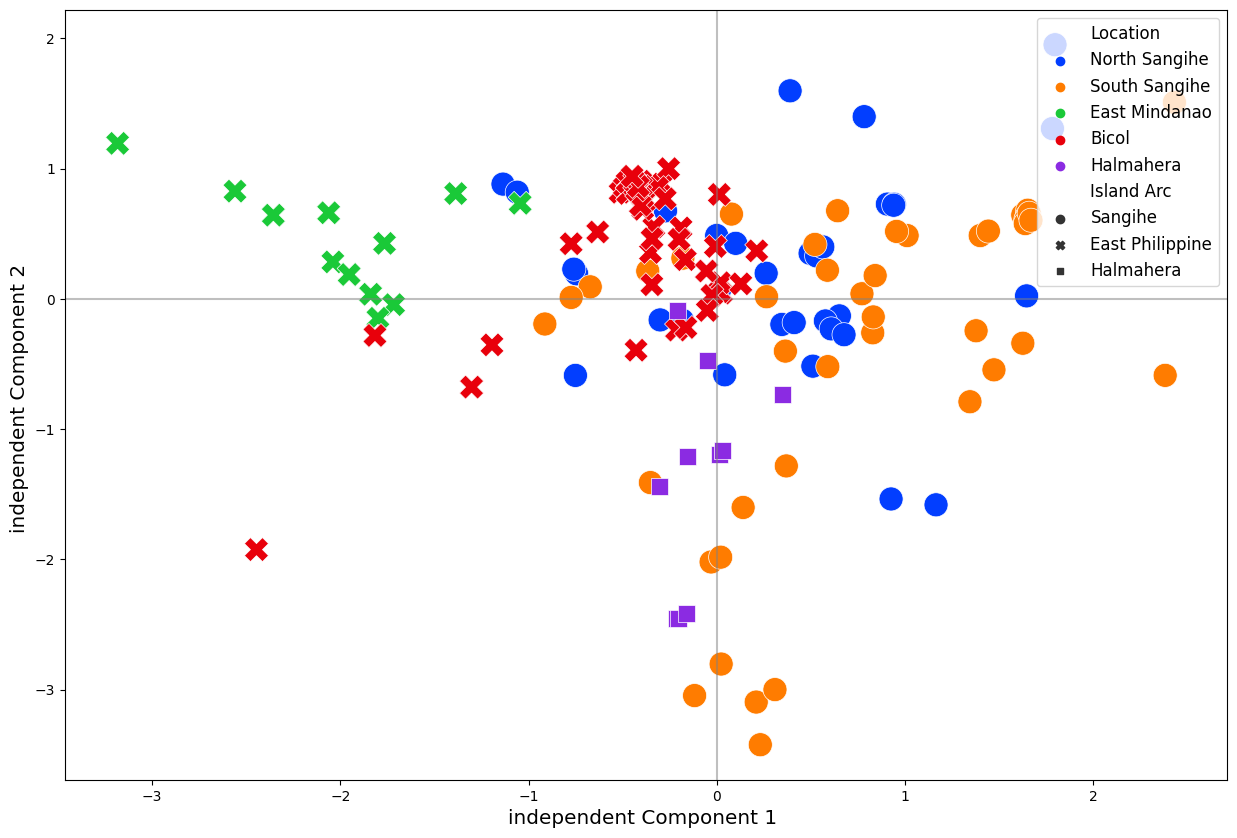

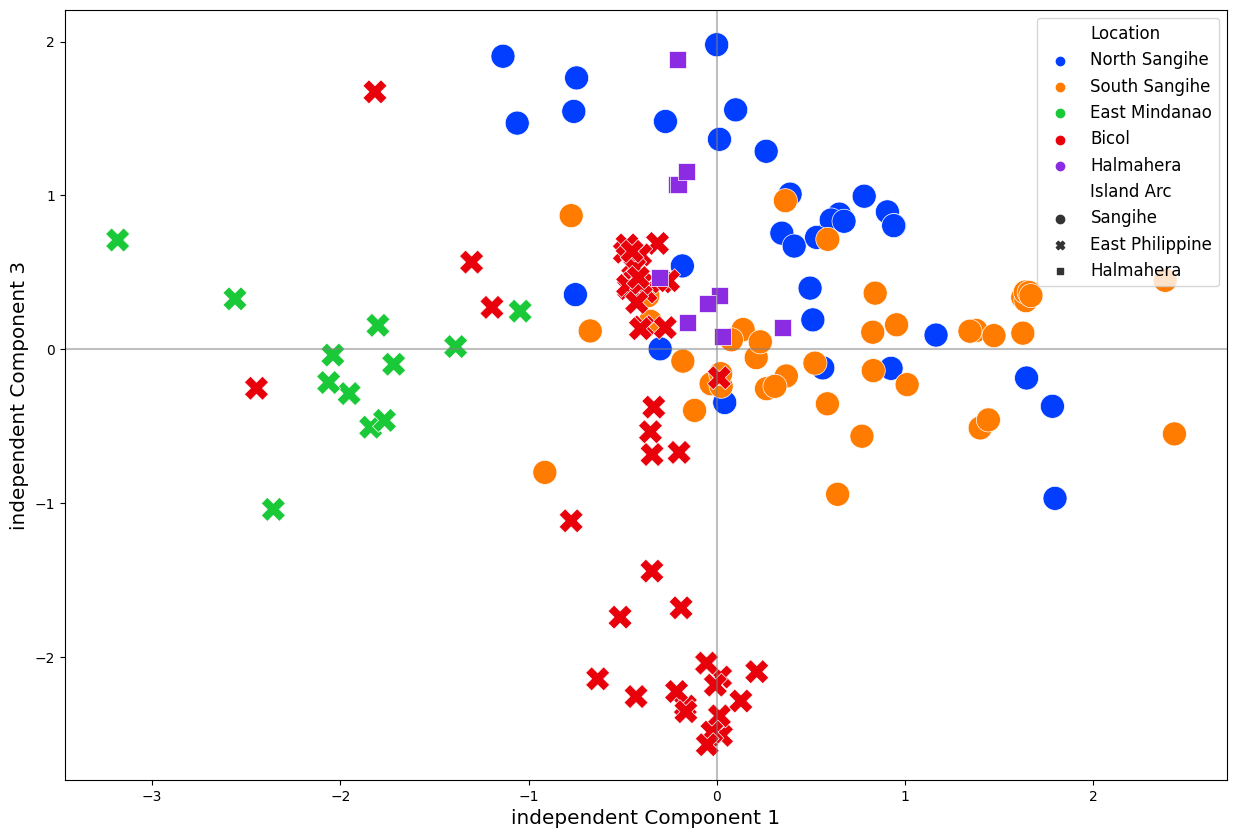

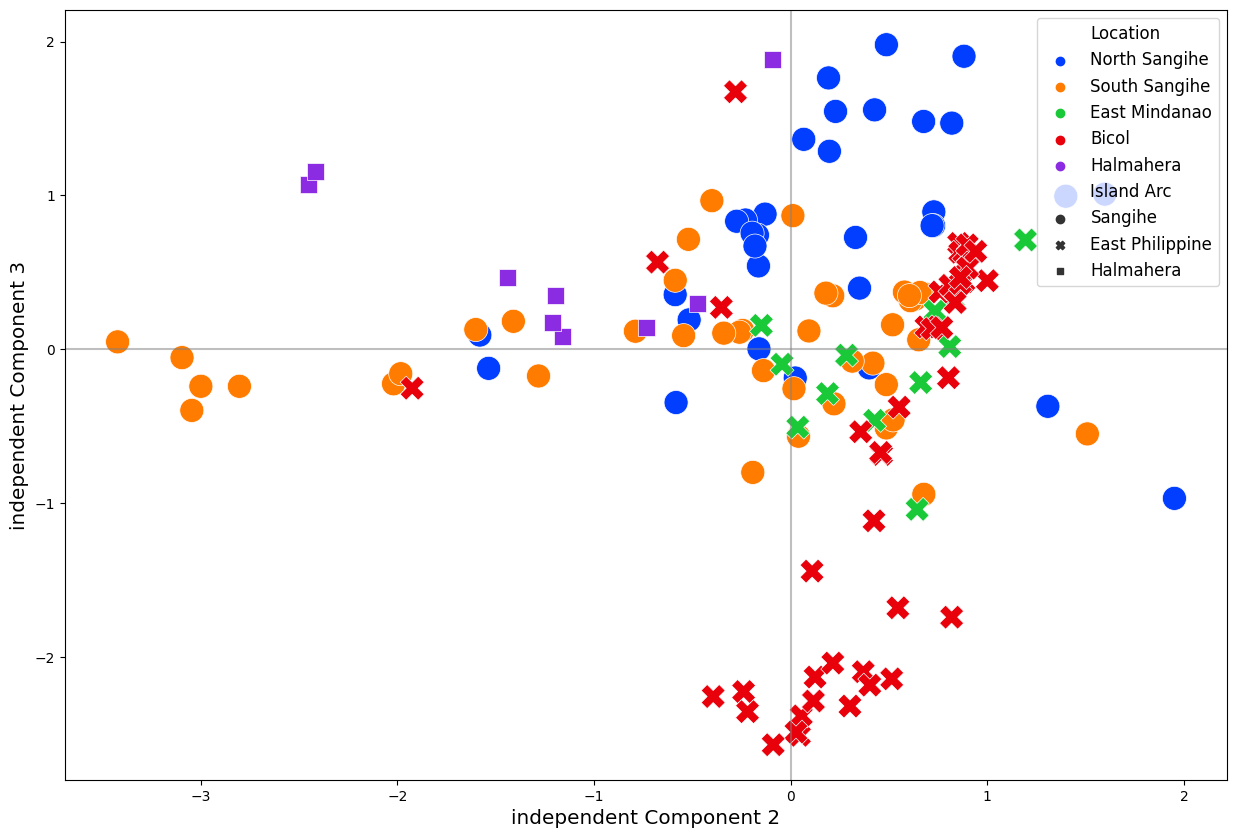

In [10]:
# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_1vs3.svg')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_2vs3.svg')

## KCA

this process just to cluster the data that already get transformed+whitened

### KCA applied to get labels

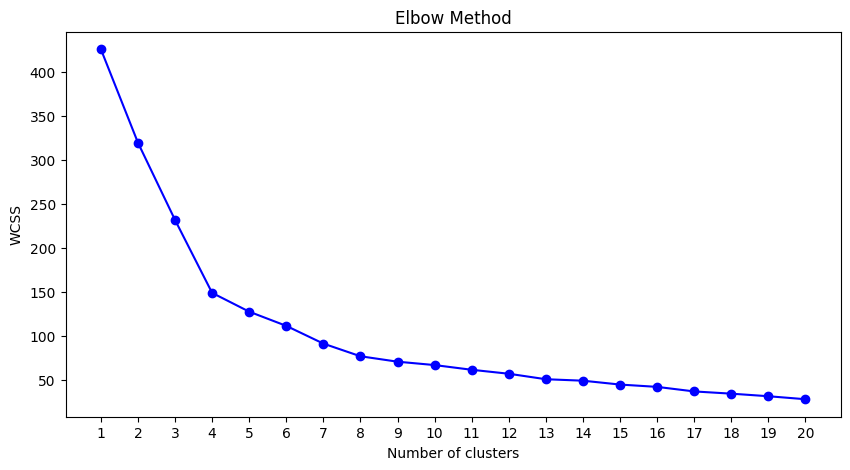

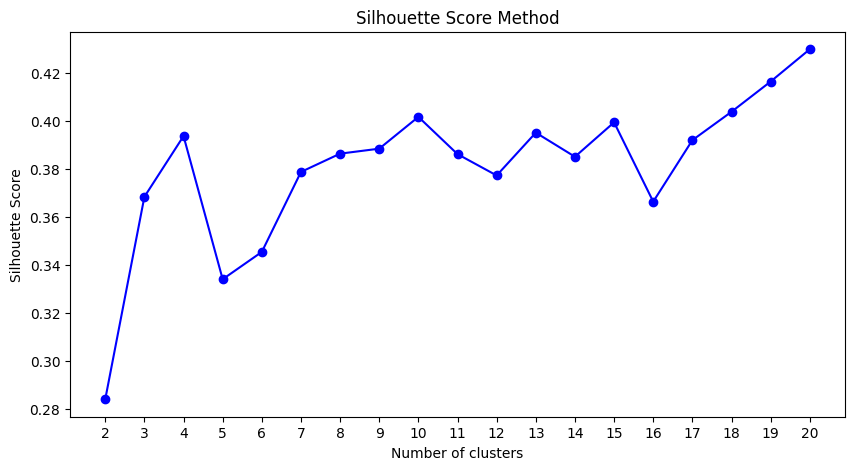

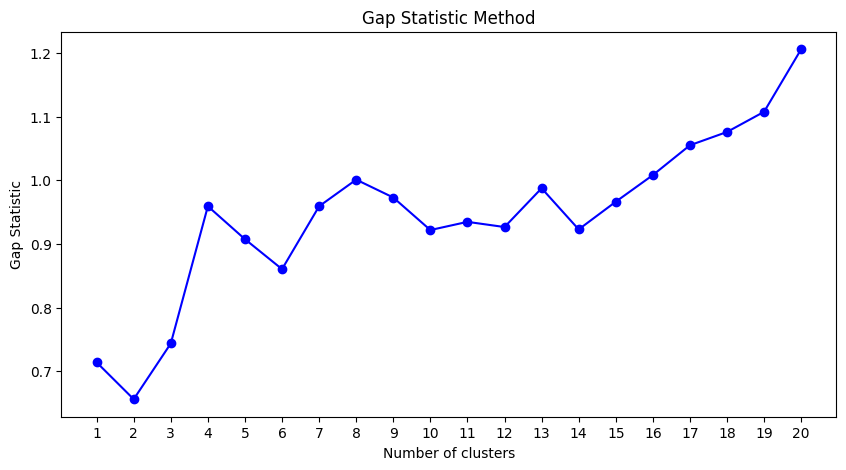

Optimal number of clusters based on Gap Statistic: 20


In [11]:
# Retrieve the first 10 columns
X = principalComponentsDataframe.iloc[:, :3].values

# Elbow Method
def elbow_method(X):
    wcss = []
    k_values = range(1, 21)
    for k in k_values:
        kmeans = KMeans(init="k-means++", n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, wcss, 'bo-')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.xticks(k_values)
    plt.show()

# Silhouette Score Method
def silhouette_method(X):
    silhouette_avg = []
    k_values = range(2, 21)
    for k in k_values:
        kmeans = KMeans(init="k-means++", n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        silhouette_avg.append(silhouette_score(X, labels))
    
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, silhouette_avg, 'bo-')
    plt.title('Silhouette Score Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_values)
    plt.show()

# Gap Statistic Method
def gap_statistic_method(X, n_refs=10, max_clusters=20):
    def compute_wcss(X, n_clusters):
        kmeans = KMeans(init="k-means++", n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans.fit(X)
        return kmeans.inertia_

    def create_reference_data(X):
        min_vals = np.min(X, axis=0)
        max_vals = np.max(X, axis=0)
        return np.random.uniform(min_vals, max_vals, X.shape)

    gaps = []
    for k in range(1, max_clusters + 1):
        actual_wcss = compute_wcss(X, k)
        ref_wcss = np.zeros(n_refs)
        for i in range(n_refs):
            X_ref = create_reference_data(X)
            ref_wcss[i] = compute_wcss(X_ref, k)
        
        gap = np.log(np.mean(ref_wcss)) - np.log(actual_wcss)
        gaps.append(gap)

    optimal_k = np.argmax(gaps) + 1  # +1 because index starts from 0
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_clusters + 1), gaps, 'bo-')
    plt.title('Gap Statistic Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Gap Statistic')
    plt.xticks(range(1, max_clusters+1))
    plt.show()

    return optimal_k

# Run the methods
elbow_method(X)
silhouette_method(X)
optimal_k = gap_statistic_method(X)
print(f'Optimal number of clusters based on Gap Statistic: {optimal_k}')

silhouette score KCA: 0.3935931455771488


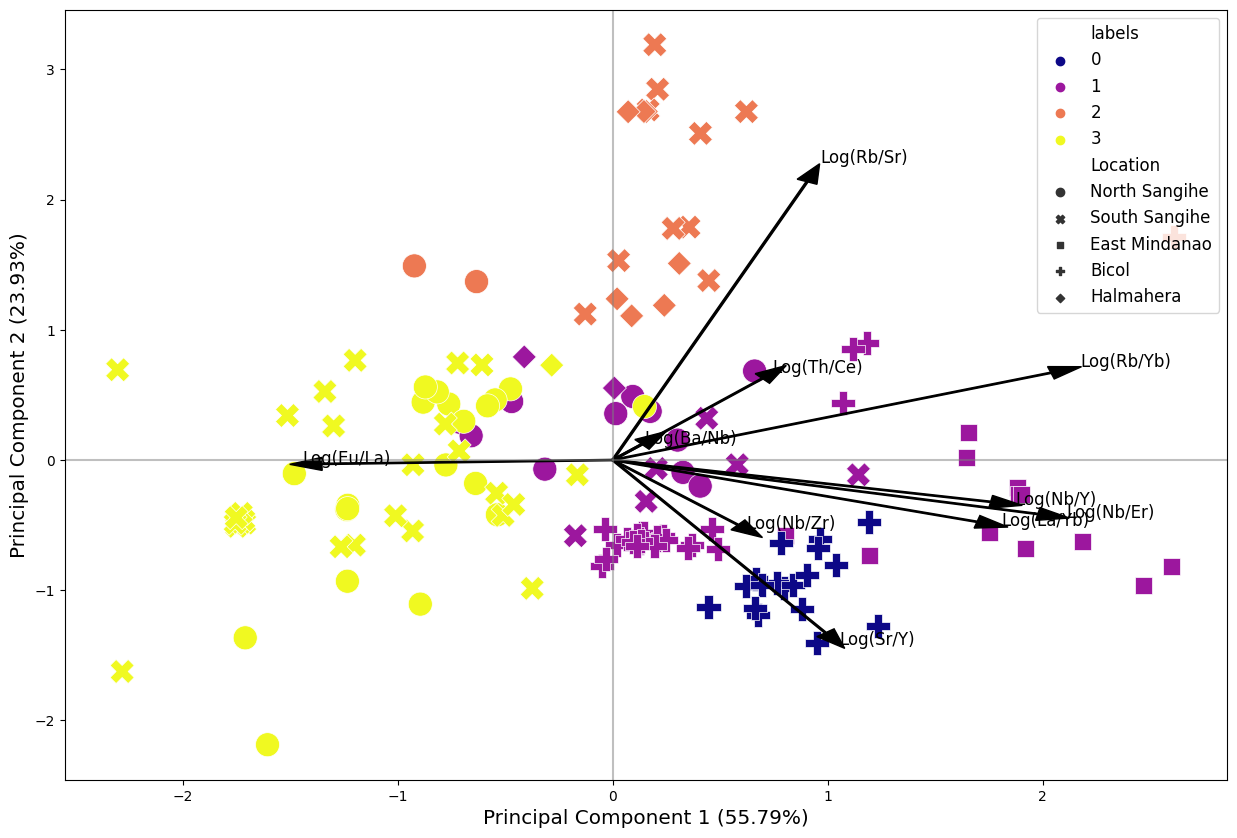

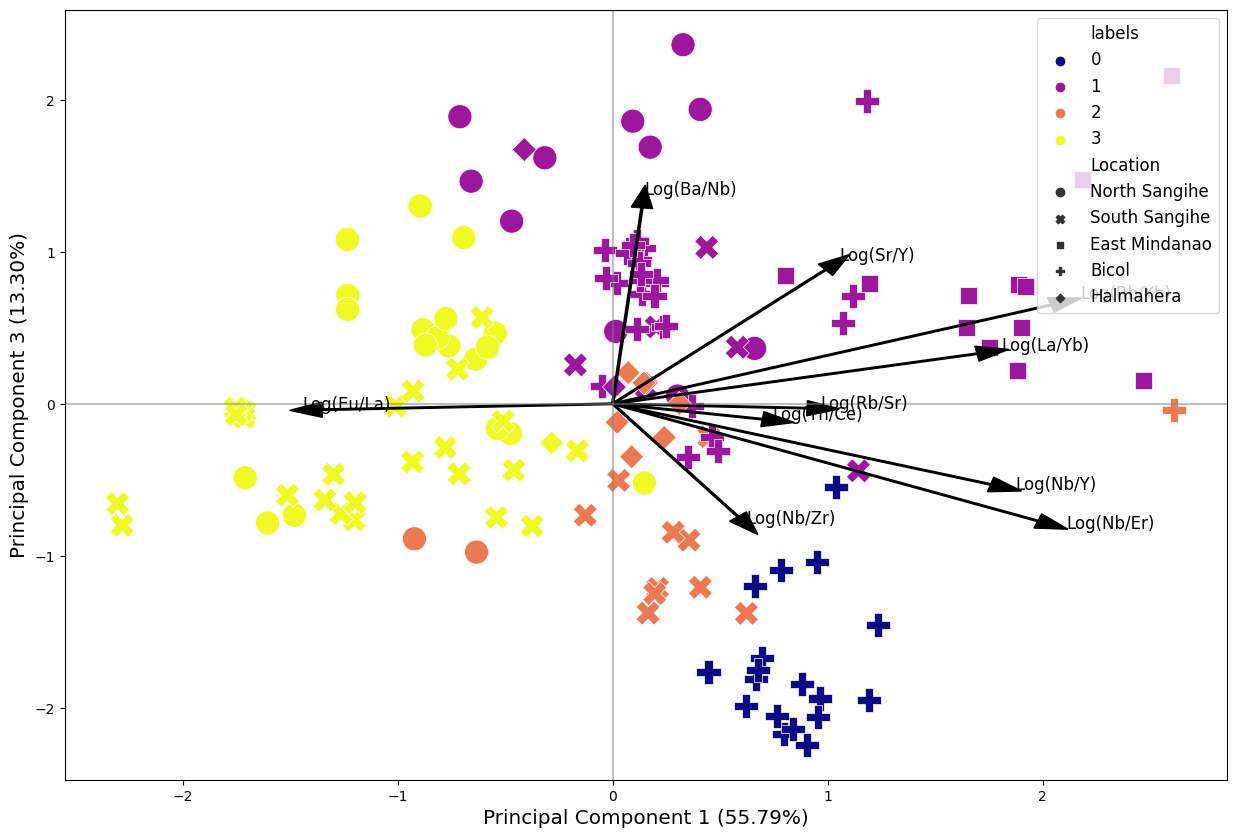

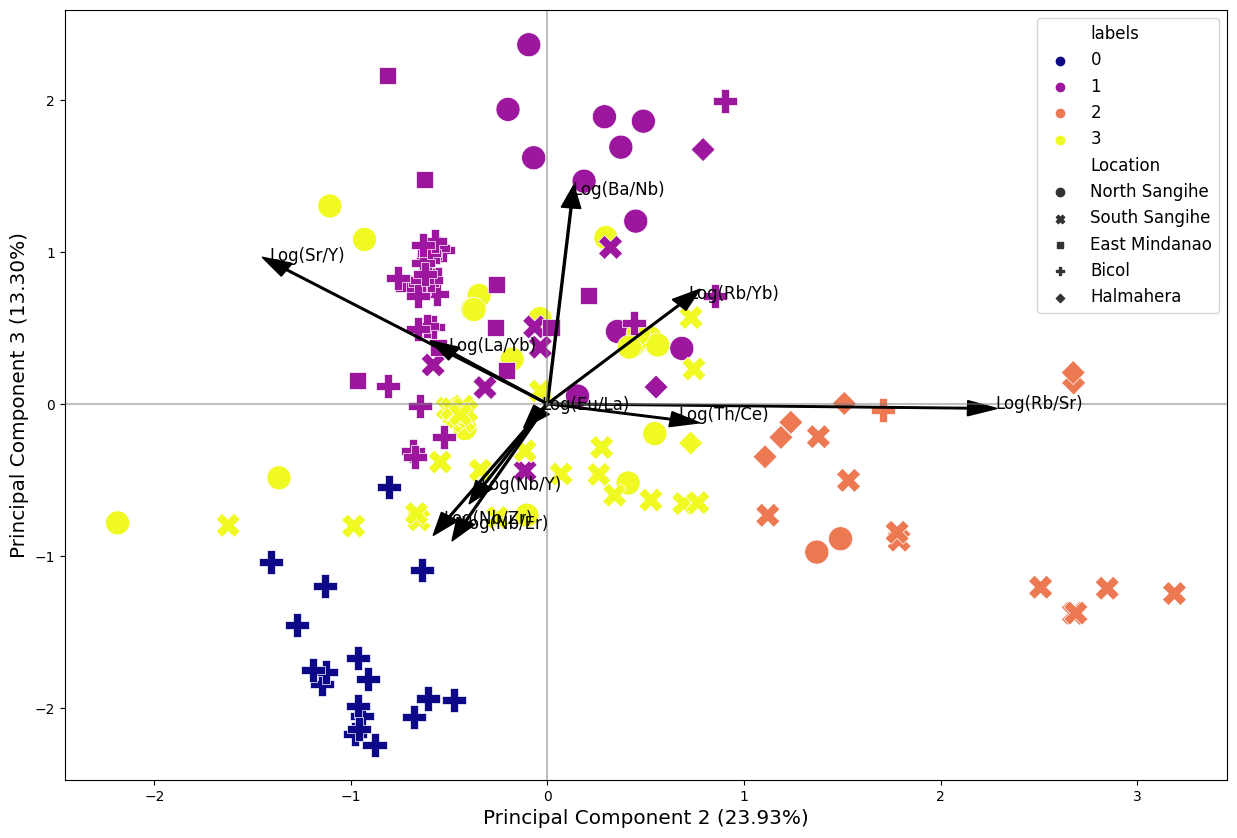

In [12]:
def kmc(principalComponentsDataframe, cluster, explainedVarianceRatio, ratio, frame, loadingVectors):
    X = principalComponentsDataframe.iloc[:, 0:3].values
    dataFrame = principalComponentsDataframe[frame]
    
    kmeans = KMeans(init="k-means++", n_clusters=cluster, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f'silhouette score KCA: {score}')

    principalComponentsDataframe["labels"] = labels

    # Plot dataset
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC1",
                    y="PC2",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(ratio):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 0],
                  3 * loadingVectors[i, 1],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 0],
                 3.2 * loadingVectors[i, 1],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC1_vs_PC2_{score}_{cluster}.svg')

    fig2, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC1",
                    y="PC3",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(ratio):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 0],
                  3 * loadingVectors[i, 2],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 0],
                 3.2 * loadingVectors[i, 2],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC1_vs_PC3_{score}_{cluster}.svg')

    fig3, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC2",
                    y="PC3",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(ratio):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 1],
                  3 * loadingVectors[i, 2],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 1],
                 3.2 * loadingVectors[i, 2],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC2_vs_PC3_{score}_{cluster}.svg')
    
    return principalComponentsDataframe
    
cluster = 4
labelDataframe = kmc(principalComponentsDataframe, cluster, explainedVarianceRatio, ratio, frame, loadingVectors)

In [13]:
labelDataframe

,PC1,PC2,PC3,Location,Longitude,Latitude,AGE,Sample Name,Island Arc,labels
0,-0.710858,0.290138,1.888581,North Sangihe,125.800,4.500,PLIOCENE [16735],s_PJ-40-78 [16735],Sangihe,1
1,-0.658482,0.186437,1.464663,North Sangihe,125.700,4.233,PLIOCENE [16735],s_PJ-43-78 [16735],Sangihe,1
2,-0.633368,1.370455,-0.975496,North Sangihe,125.716,3.866,PLIOCENE [16735],s_PJ-45-78 [16735],Sangihe,2
3,-0.881651,0.444627,0.486689,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PBUANG [16735],Sangihe,3
4,-0.470002,0.449362,1.201774,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PJ-5-78 [16735],Sangihe,1
...,...,...,...,...,...,...,...,...,...,...
138,0.309584,1.510099,0.002306,Halmahera,127.330,0.800,NaN,s_GL [25001],Halmahera,2
139,0.007766,0.552644,0.110468,Halmahera,127.350,0.300,NaN,s_MK1 [25001],Halmahera,1
140,0.088146,1.107207,-0.348361,Halmahera,127.350,0.300,NaN,s_MK2 [25001],Halmahera,2
141,0.239942,1.188044,-0.220848,Halmahera,127.350,0.300,NaN,s_MK3 [25001],Halmahera,2


In [14]:
pcAndOriginal = pd.concat([labelDataframe, concatData[ratio]], axis=1, join='inner')
pcIcAndOrginal = pd.concat([pcAndOriginal, pcIcAndOrginal[["IC1", "IC2", "IC3"]]], axis=1, join='inner')
pcIcAndOrginal

,PC1,PC2,PC3,Location,Longitude,Latitude,AGE,Sample Name,Island Arc,labels,...,Log(Sr/Y),Log(Rb/Sr),Log(Th/Ce),Log(Eu/La),Log(Rb/Yb),Log(Nb/Y),Log(Nb/Er),IC1,IC2,IC3
0,-0.710858,0.290138,1.888581,North Sangihe,125.800,4.500,PLIOCENE [16735],s_PJ-40-78 [16735],Sangihe,1,...,0.194879,-0.234209,-0.386319,0.535025,-0.112980,-1.051424,-1.178891,-0.001233,0.486504,1.979785
1,-0.658482,0.186437,1.464663,North Sangihe,125.700,4.233,PLIOCENE [16735],s_PJ-43-78 [16735],Sangihe,1,...,0.068543,-0.312594,-0.321744,0.368156,-0.325580,-0.903239,-1.026008,0.099684,0.426444,1.556215
2,-0.633368,1.370455,-0.975496,North Sangihe,125.716,3.866,PLIOCENE [16735],s_PJ-45-78 [16735],Sangihe,2,...,-1.137030,0.641808,-0.039603,0.590064,-0.751012,-0.217539,-0.416705,0.925068,-1.536134,-0.124242
3,-0.881651,0.444627,0.486689,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PBUANG [16735],Sangihe,3,...,-0.470269,-0.194750,-0.304354,0.301907,-0.713532,-0.928129,-0.981689,0.650532,-0.130419,0.878447
4,-0.470002,0.449362,1.201774,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PJ-5-78 [16735],Sangihe,1,...,0.080823,0.000549,-0.264925,0.464705,-0.021091,-0.803915,-0.952589,0.013631,0.066311,1.364737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.309584,1.510099,0.002306,Halmahera,127.330,0.800,NaN,s_GL [25001],Halmahera,2,...,-0.726472,0.853083,0.623088,-0.193864,0.100775,-0.352225,-0.246034,-0.302651,-1.438029,0.465533
139,0.007766,0.552644,0.110468,Halmahera,127.350,0.300,NaN,s_MK1 [25001],Halmahera,1,...,-0.364939,0.030278,0.353217,0.062495,-0.140755,-0.517232,-0.303940,-0.050538,-0.474395,0.300125
140,0.088146,1.107207,-0.348361,Halmahera,127.350,0.300,NaN,s_MK2 [25001],Halmahera,2,...,-0.682774,0.483914,0.372440,-0.037989,-0.063268,-0.340608,-0.227400,0.031192,-1.160639,0.083529
141,0.239942,1.188044,-0.220848,Halmahera,127.350,0.300,NaN,s_MK3 [25001],Halmahera,2,...,-0.619194,0.589125,0.355978,-0.008430,0.149956,-0.321838,-0.041575,-0.156397,-1.209512,0.174404


### ICA + Clusters Label 

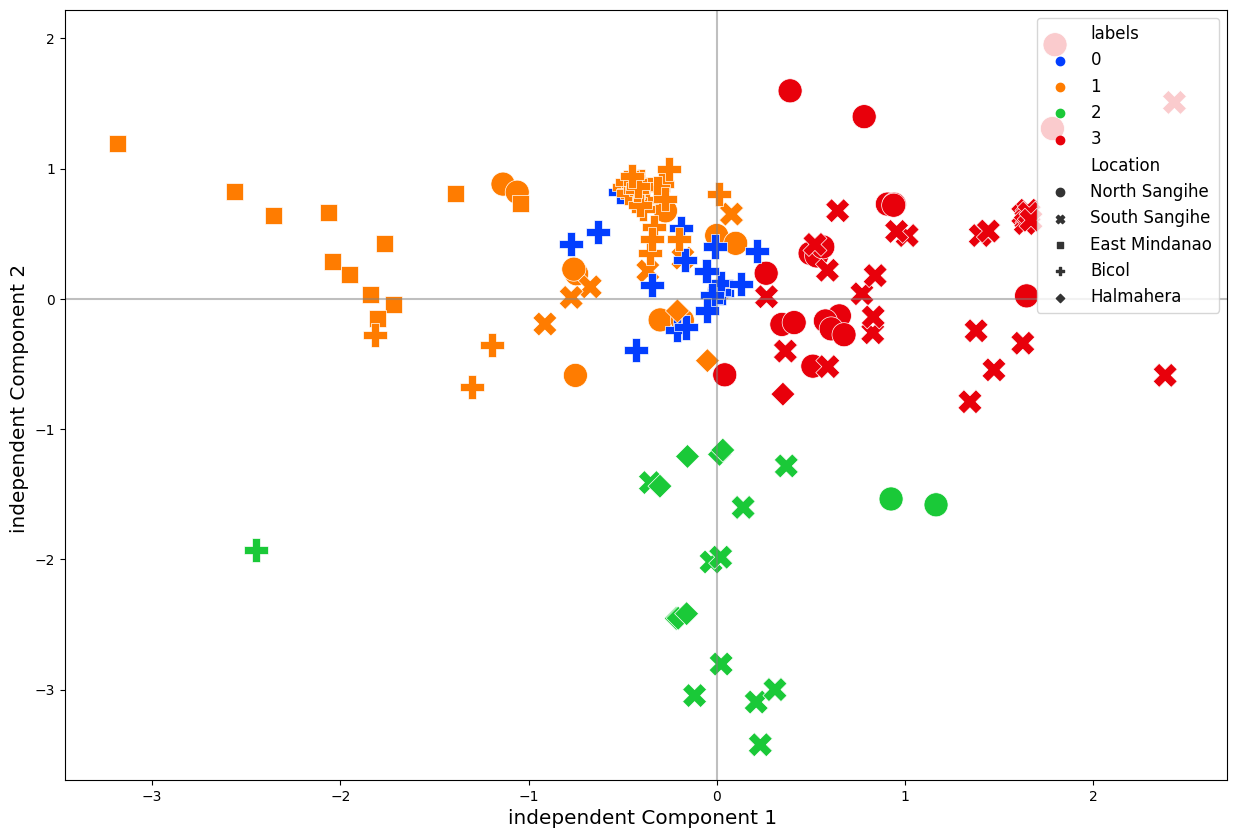

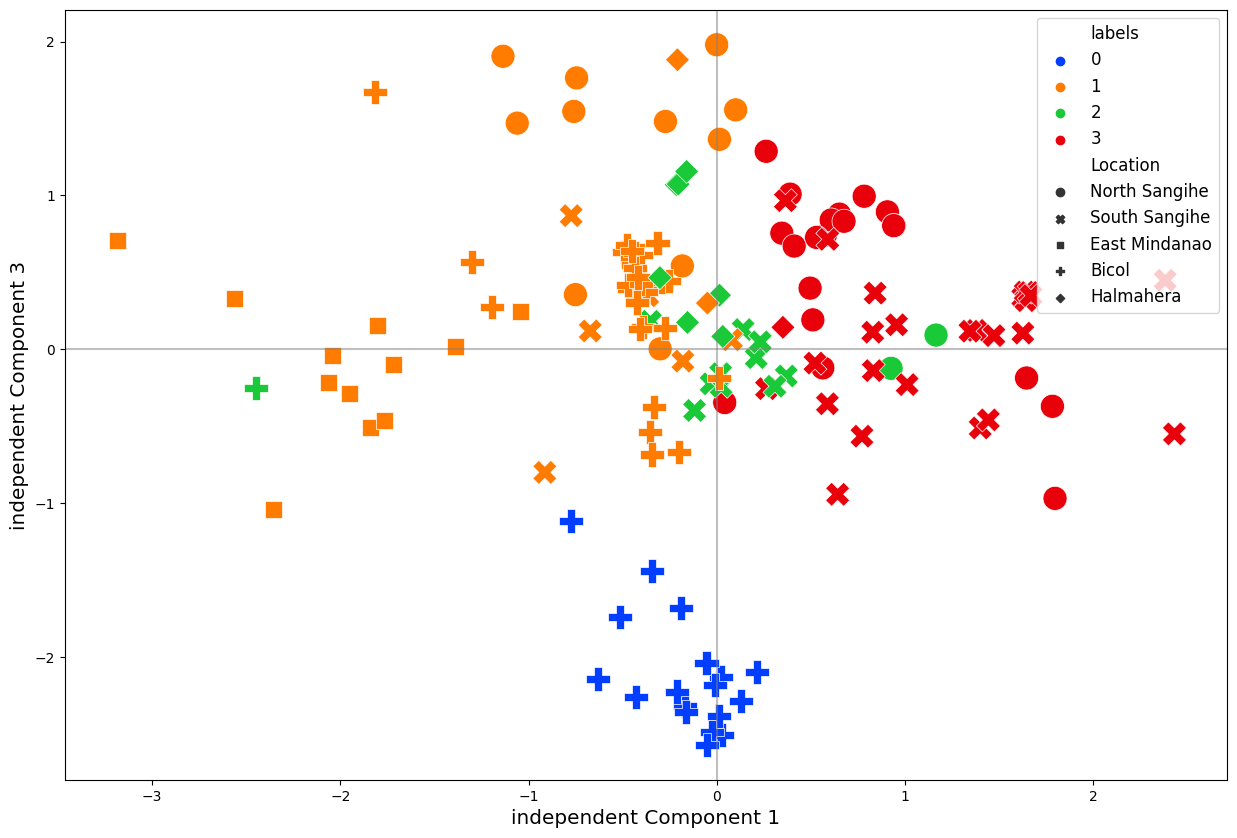

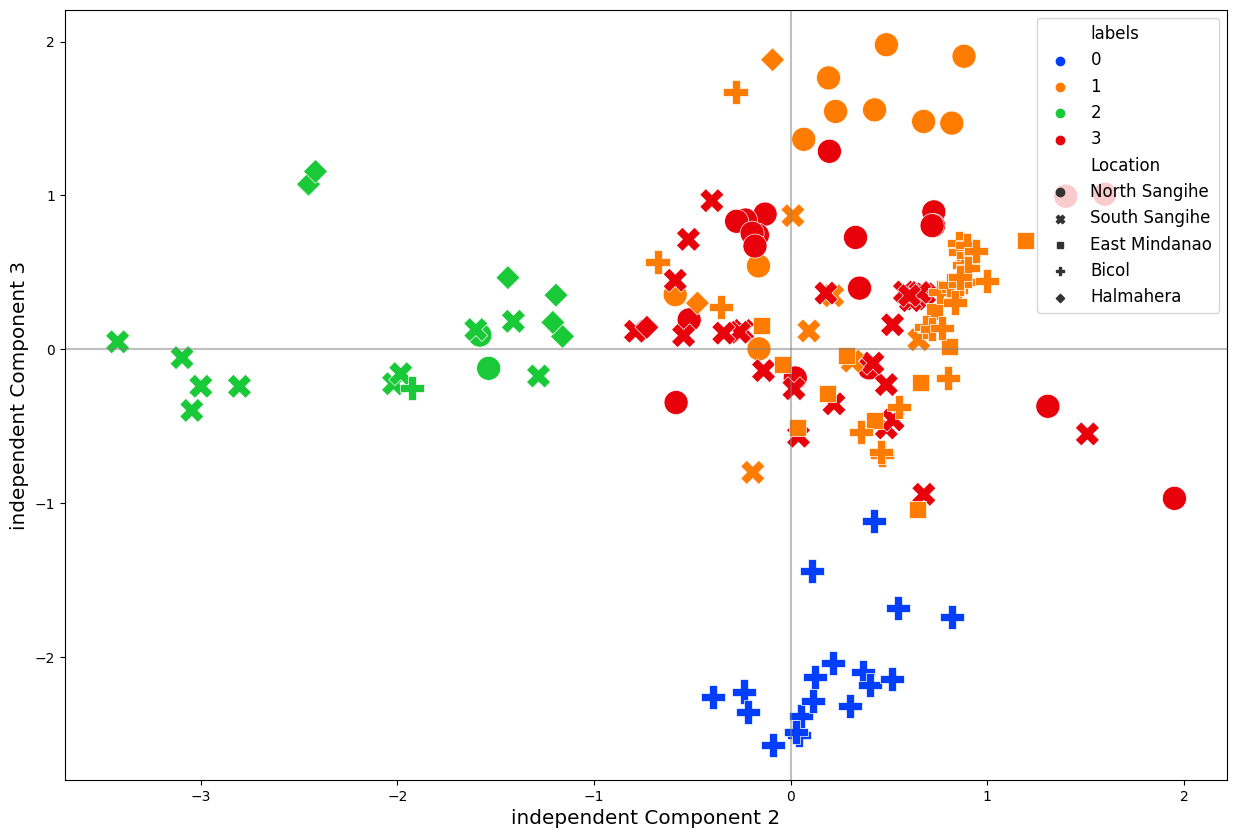

In [15]:
# ICA + Label
# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='bright',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='bright',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_1vs3.svg')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='bright',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_2vs3.svg')

### Original Components + Clusters Label

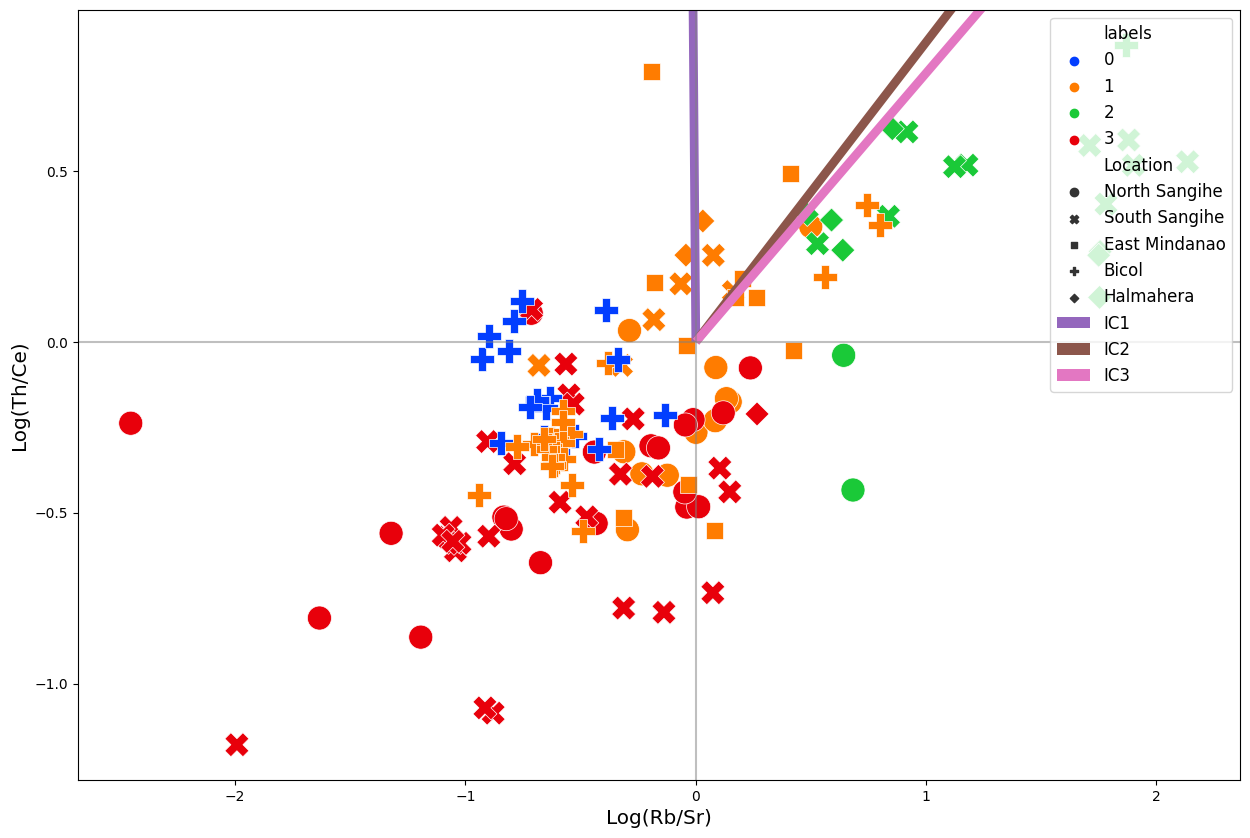

In [16]:
# original and labels
## Log(Sr/Y) vs Log(Nb/Zr)
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="Log(Rb/Sr)",
                y="Log(Th/Ce)",
                s=300,
                palette='bright',
                style="Location",
                hue="labels")
plt.xlabel(f'Log(Rb/Sr)', fontsize="x-large")
plt.ylabel(f'Log(Th/Ce)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, (ic_vector) in enumerate(icVectors):
    plt.quiver(0, 0, ic_vector[0], ic_vector[1], angles='xy', scale_units='xy', color=f'C{i+4}', scale=0.05, label=f'IC{i+1}')
plt.legend(fontsize="large", loc=1)
plt.savefig(f'Rb_SrvsTh_Ce_label_trace.svg')

## Map

In [17]:
def transform_latitude(lat):
    if lat < -6:
        return abs(lat)
    return lat

pcIcAndOrginal['Latitude'] = pcIcAndOrginal['Latitude'].apply(transform_latitude)

# Create geometry column with Point objects
pcIcAndOrginal['geometry'] = [Point(xy) for xy in zip(pcIcAndOrginal['Longitude'], pcIcAndOrginal['Latitude'])]

# Create a GeoDataFrame
geoDataframe = gpd.GeoDataFrame(pcIcAndOrginal, geometry='geometry')

# Set CRS to EPSG:4326 (WGS 84)
geoDataframe.set_crs(epsg=4326, inplace=True)

# Initialize a Folium map centered at the average latitude and longitude
map_center = [geoDataframe['Latitude'].mean(), geoDataframe['Longitude'].mean()]

# IC 1
m = folium.Map(location=map_center, zoom_start=5)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC1'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC1'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC1'], color_scale)
        )
    ).add_to(m)

# Add color scale legend to the map
color_scale.add_to(m)

# Display the map inline
display(m)


/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [18]:
# IC 2
l = folium.Map(location=map_center, zoom_start=5)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC2'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC2'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC2'], color_scale)
        )
    ).add_to(l)

# Add color scale legend to the map
color_scale.add_to(l)

# Display the map inline
display(l)

In [19]:
# IC 3
k = folium.Map(location=map_center, zoom_start=5)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC3'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC3'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC3'], color_scale)
        )
    ).add_to(k)

# Add color scale legend to the map
color_scale.add_to(k)

# Display the map inline
display(k)